In [ ]:
!pip install roboflow
!pip install ultralytics  # YOLOv9 might be part of ultralytics package

from roboflow import Roboflow
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import yaml
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 28.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KMnKzp2xY8Y9XZKQj5tx")
project = rf.workspace("yasai").project("yasai-ninshiki")
version = project.version(7)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Yasai-Ninshiki-7 in yolov8:: 100%|██████████| 18062/18062 [00:02<00:00, 7745.45it/s]


In [ ]:
# Define paths to your training, validation, and test sets
train_images_path = "/content/Yasai-Ninshiki-7/train/images"
train_labels_path = "/content/Yasai-Ninshiki-7/train/labels"
val_images_path = "/content/Yasai-Ninshiki-7/valid/images"
val_labels_path = "/content/Yasai-Ninshiki-7/valid/labels"
test_images_path = "/content/Yasai-Ninshiki-7/test/images"
test_labels_path = "/content/Yasai-Ninshiki-7/test/labels"

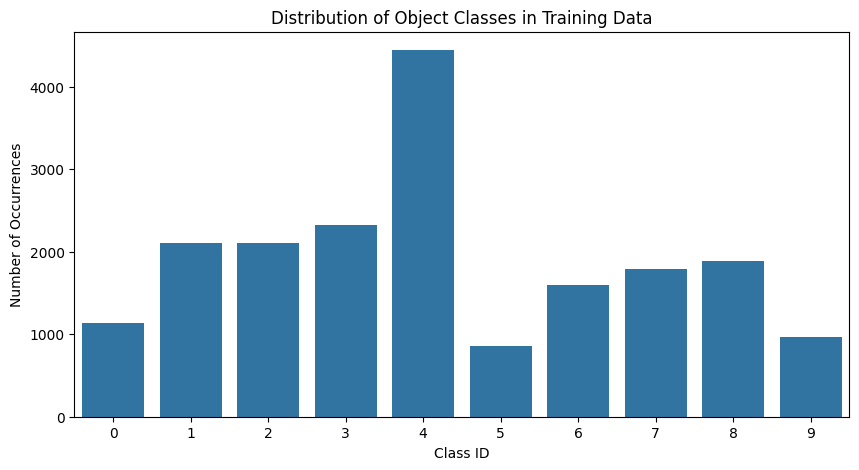

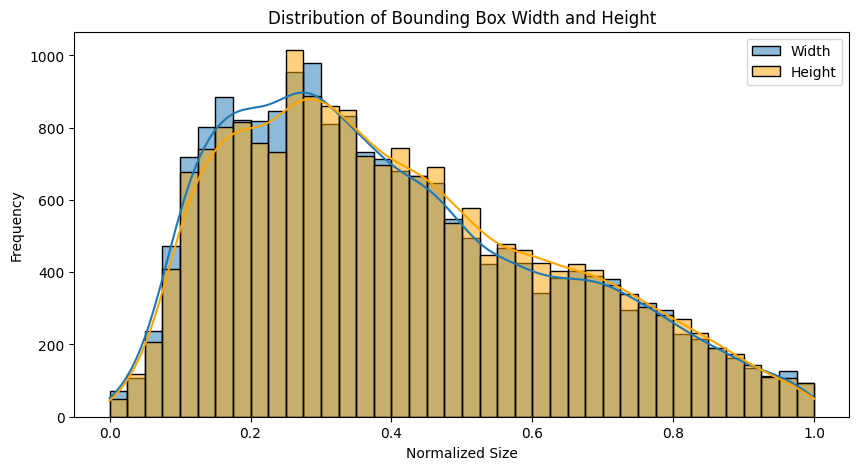

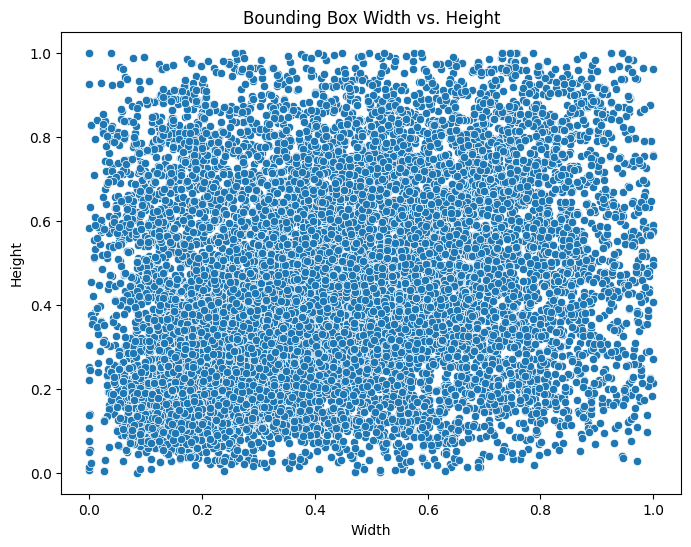

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def parse_yolo_label(label_file):
    """Parses a YOLO label file and returns a list of bounding box information.
    Handles lines with extra values by truncating or skipping them.
    """
    with open(label_file, 'r') as f:
        lines = f.readlines()
    bboxes = []
    for line in lines:
        values = line.strip().split()
        if len(values) >= 5:  # Check if there are enough values
            # Truncate to 5 values if there are more
            class_id, x_center, y_center, width, height = map(float, values[:5])
            bboxes.append({
                'class_id': int(class_id),
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })
        else:
            print(f"Warning: Skipping line with insufficient values in {label_file}: {line.strip()}")
    return bboxes

# Create empty lists to store label information
image_filenames = []
class_ids = []
bbox_widths = []
bbox_heights = []

# Loop through the training label files
for filename in os.listdir(train_labels_path):
  if filename.endswith(".txt"):
    label_file = os.path.join(train_labels_path, filename)
    bboxes = parse_yolo_label(label_file)
    for bbox in bboxes:
      image_filenames.append(filename.replace(".txt", ".jpg"))  # Assuming image files are .jpg
      class_ids.append(bbox['class_id'])
      bbox_widths.append(bbox['width'])
      bbox_heights.append(bbox['height'])

# Create a DataFrame for analysis
label_df = pd.DataFrame({
    'image_filename': image_filenames,
    'class_id': class_ids,
    'bbox_width': bbox_widths,
    'bbox_height': bbox_heights
})


# 1. Class Distribution
class_counts = label_df['class_id'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Object Classes in Training Data')
plt.xlabel('Class ID')
plt.ylabel('Number of Occurrences')
plt.show()

# 2. Bounding Box Size Analysis
plt.figure(figsize=(10, 5))
sns.histplot(label_df['bbox_width'], kde=True, label='Width')
sns.histplot(label_df['bbox_height'], kde=True, label='Height', color='orange')
plt.title('Distribution of Bounding Box Width and Height')
plt.xlabel('Normalized Size')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 3. Relationship between Bounding Box Width and Height (Optional)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bbox_width', y='bbox_height', data=label_df)
plt.title('Bounding Box Width vs. Height')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [ ]:
def create_dataframe_from_labels(label_directory, label_names):
    data = {'image_file': [], 'class_id': [], 'x_center': [], 'y_center': [], 'width': [], 'height': []}
    for filename in os.listdir(label_directory):
        if filename.endswith(".txt"):
            image_file = filename.replace(".txt", ".jpg")  # Assuming images are JPG
            with open(os.path.join(label_directory, filename), "r") as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])

                    data['image_file'].append(image_file)
                    data['class_id'].append(class_id)
                    data['x_center'].append(x_center)
                    data['y_center'].append(y_center)
                    data['width'].append(width)
                    data['height'].append(height)

    df = pd.DataFrame(data)
    if label_names:
        df['class_name'] = df['class_id'].map(lambda x: label_names[x] if x < len(label_names) else 'Unknown')
    return df

# Create DataFrame for analysis
df = create_dataframe_from_labels(train_labels_path, None)

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler # Import StandardScaler

def create_dataframe_from_labels(label_directory, label_names):
    data = {'image_file': [], 'class_id': [], 'x_center': [], 'y_center': [], 'width': [], 'height': []}
    for filename in os.listdir(label_directory):
        if filename.endswith(".txt"):
            image_file = filename.replace(".txt", ".jpg")  # Assuming images are JPG
            with open(os.path.join(label_directory, filename), "r") as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])

                    data['image_file'].append(image_file)
                    data['class_id'].append(class_id)
                    data['x_center'].append(x_center)
                    data['y_center'].append(y_center)
                    data['width'].append(width)
                    data['height'].append(height)

    df = pd.DataFrame(data)
    if label_names:
        df['class_name'] = df['class_id'].map(lambda x: label_names[x] if x < len(label_names) else 'Unknown')
    return df

# Create DataFrames for analysis for train, validation and test sets
train_df = create_dataframe_from_labels(train_labels_path, None) # Assign to train_df
val_df = create_dataframe_from_labels(val_labels_path, None) # Assign to val_df
test_df = create_dataframe_from_labels(test_labels_path, None) # Assign to test_df

# Apply preprocessing (scaling, etc.) to training, validation, and test DataFrames
scaler = StandardScaler()

# Preprocess train data
train_df[['x_center', 'y_center', 'width', 'height']] = scaler.fit_transform(
    train_df[['x_center', 'y_center', 'width', 'height']]
)

# Preprocess validation data using the same scaler
val_df[['x_center', 'y_center', 'width', 'height']] = scaler.transform(
    val_df[['x_center', 'y_center', 'width', 'height']]
)

# Preprocess test data using the same scaler
test_df[['x_center', 'y_center', 'width', 'height']] = scaler.transform(
    test_df[['x_center', 'y_center', 'width', 'height']]
)

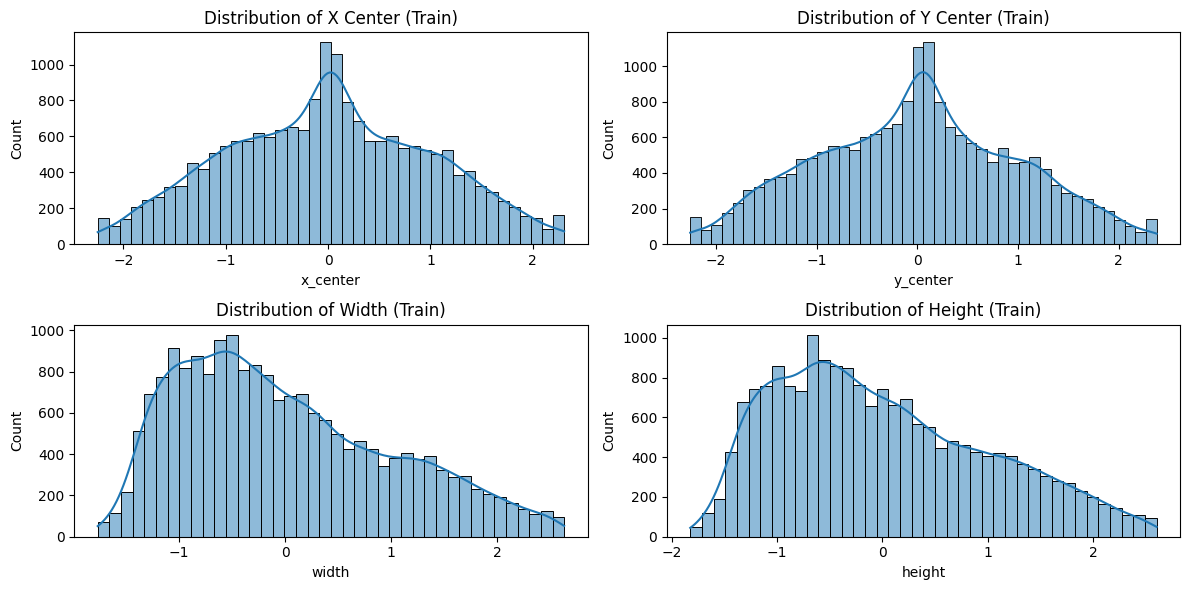

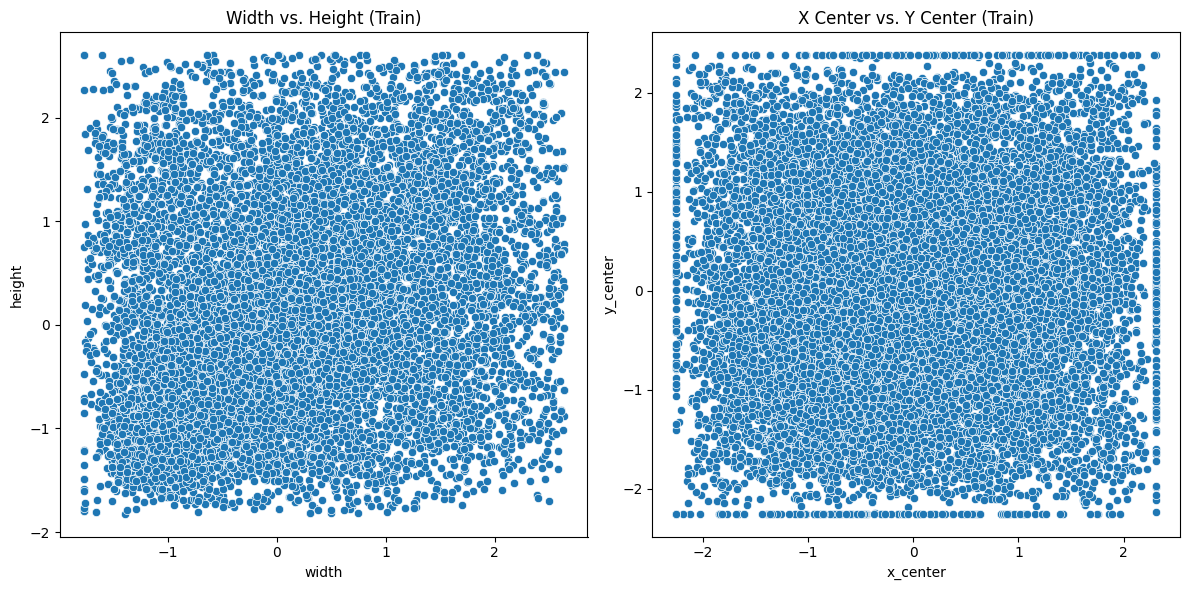

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize preprocessed data for training set
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(train_df['x_center'], kde=True)
plt.title('Distribution of X Center (Train)')

plt.subplot(2, 2, 2)
sns.histplot(train_df['y_center'], kde=True)
plt.title('Distribution of Y Center (Train)')

plt.subplot(2, 2, 3)
sns.histplot(train_df['width'], kde=True)
plt.title('Distribution of Width (Train)')

plt.subplot(2, 2, 4)
sns.histplot(train_df['height'], kde=True)
plt.title('Distribution of Height (Train)')
plt.tight_layout()
plt.show()

# Scatter plots to visualize relationships between variables in the training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='width', y='height', data=train_df)
plt.title('Width vs. Height (Train)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='x_center', y='y_center', data=train_df)
plt.title('X Center vs. Y Center (Train)')
plt.tight_layout()
plt.show()


Error processing image: /content/Yasai-Ninshiki-7/train/images/IMG_9246_jpg.rf.75d7f2a63472d76130b06a73cc655850.jpg, too many values to unpack (expected 5)


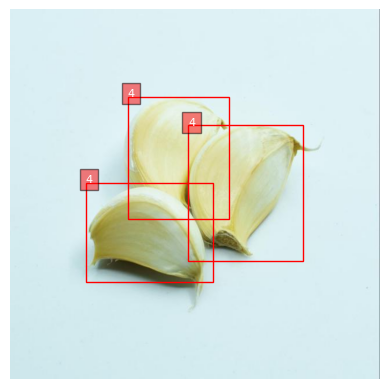

Error processing image: /content/Yasai-Ninshiki-7/train/images/222_jpg.rf.aa8f075ca3fb31864e450b6ef4765ace.jpg, too many values to unpack (expected 5)


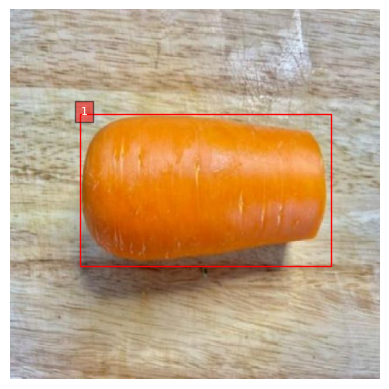

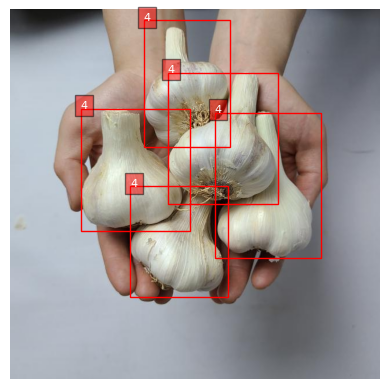

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

def plot_image_with_labels(image_path, label_path, class_names=None):
  """
  Plots an image with bounding boxes and labels.

  Args:
    image_path: Path to the image file.
    label_path: Path to the corresponding label file.
    class_names: A list of class names for mapping class IDs to labels.
  """

  try:
    img = Image.open(image_path)
    plt.imshow(img)
    ax = plt.gca()

    with open(label_path, 'r') as f:
      for line in f:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        x_center = x_center * img.width
        y_center = y_center * img.height
        width = width * img.width
        height = height * img.height

        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        if class_names:
          label = class_names.get(int(class_id), 'Unknown')
        else:
          label = str(int(class_id))

        plt.text(x_min, y_min, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

  except Exception as e:
    print(f"Error processing image: {image_path}, {e}")



for filename in os.listdir(train_labels_path)[:5]:  # Process only the first 5 images
    if filename.endswith(".txt"):
        image_file = filename.replace(".txt", ".jpg")
        image_path = os.path.join(train_images_path, image_file)
        label_path = os.path.join(train_labels_path, filename)
        plot_image_with_labels(image_path, label_path)

In [ ]:
from ultralytics import YOLO
import os
import yaml

# Load the YOLOv8 model
model = YOLO('yolov8x.pt')  # Make sure to specify the correct model file

# Get label names from the dataset
def get_label_names_from_dataset(dataset_path):
    """
    Attempts to get label names from the dataset's data.yaml file (Roboflow).

    Args:
        dataset_path: Path to the dataset directory.

    Returns:
        A list of label names (strings) or None if not found.
    """
    data_yaml_path = os.path.join(dataset_path, "data.yaml")
    if os.path.exists(data_yaml_path):
        with open(data_yaml_path, "r") as f:
            try:
                data = yaml.safe_load(f)
                return data.get("names", [])
            except yaml.YAMLError as exc:
                print(f"YAML Error: {exc}")
    return None

dataset_path = "/content/Yasai-Ninshiki-7"  # Update with your actual dataset path
label_names = get_label_names_from_dataset(dataset_path)

if label_names:
    print("Label Names:", label_names)
else:
    print("Could not find label names in data.yaml. Please check the file.")
    exit()  # Exit if label names are not found

# Paths to train, validation, and test images (update these paths)
train_images_path = "/content/Yasai-Ninshiki-7/train/images" # Changed to train
val_images_path = "/content/Yasai-Ninshiki-7/valid/images"
test_images_path = "/content/Yasai-Ninshiki-7/test/images"

# Create a data.yaml file only if it doesn't exist
data_yaml_path = 'data.yaml'
if not os.path.exists(data_yaml_path):
    data_yaml = {
        'train': train_images_path,
        'val': val_images_path,
        'test': test_images_path,
        'nc': len(label_names),  # Number of classes based on label names
        'names': label_names  # Use the label names from the dataset
    }

    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_yaml, f)
    print(f"Created data.yaml at {data_yaml_path}")
else:
    print(f"Using existing data.yaml at {data_yaml_path}")

# Train the model, referencing the data.yaml file
model.train(
    data=data_yaml_path,  # Path to your data.yaml file
    epochs=12,
    batch=40,  # Reduced batch size to 8
    imgsz=640,
    project='yolo_v8_fruits_veg',
    amp=True,  # Mixed precision training
    device='0'  # Corrected to '0' for the first GPU
)


Label Names: ['Broccoli', 'Carrot', 'Cucumber', 'Eggplant', 'Garlic', 'Green pepper', 'Onion', 'Paprika', 'Potato', 'Tomato']
Using existing data.yaml at data.yaml
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=12, time=None, patience=100, batch=40, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=yolo_v8_fruits_veg, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False,

train: Scanning /content/Yasai-Ninshiki-7/train/labels.cache... 7917 images, 21 backgrounds, 0 corrupt: 100%|██████████| 7917/7917 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 6744, len(boxes) = 19212. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Yasai-Ninshiki-7/valid/labels.cache... 743 images, 0 backgrounds, 0 corrupt: 100%|██████████| 743/743 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 671, len(boxes) = 1886. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to yolo_v8_fruits_veg/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.000625), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_v8_fruits_veg/train4
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12      38.2G     0.9957      1.817      1.447        184        640: 100%|██████████| 198/198 [01:40<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


                   all        743       1886      0.563      0.473       0.47      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12      37.5G      1.126      1.588      1.533        168        640: 100%|██████████| 198/198 [01:40<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


                   all        743       1886      0.393      0.435       0.37      0.253
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12      37.4G      1.084      1.596      1.537         72        640: 100%|██████████| 198/198 [01:39<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


                   all        743       1886      0.511      0.572       0.58      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12      38.3G     0.9801      1.318      1.448        100        640: 100%|██████████| 198/198 [01:36<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


                   all        743       1886      0.653      0.663      0.704      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12      38.3G     0.9114      1.143      1.381         80        640: 100%|██████████| 198/198 [01:36<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


                   all        743       1886      0.676      0.607      0.647      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/12      38.1G     0.8584      1.006      1.338         98        640: 100%|██████████| 198/198 [01:37<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


                   all        743       1886      0.699      0.715      0.756      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/12      38.1G     0.8118     0.9042      1.303         86        640: 100%|██████████| 198/198 [01:37<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


                   all        743       1886        0.8       0.79      0.851       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/12      38.2G     0.7784      0.825      1.272         88        640: 100%|██████████| 198/198 [01:36<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

                   all        743       1886      0.779       0.78      0.845      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/12      38.1G     0.7404     0.7509      1.238         90        640: 100%|██████████| 198/198 [01:36<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]

                   all        743       1886      0.797       0.79      0.843      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/12        38G     0.7049       0.68      1.219         80        640: 100%|██████████| 198/198 [01:36<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

                   all        743       1886      0.842      0.787      0.856      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/12        38G     0.6706     0.6089      1.184         81        640: 100%|██████████| 198/198 [01:36<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

                   all        743       1886      0.836      0.796      0.868      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/12        38G     0.6386     0.5453      1.158         87        640: 100%|██████████| 198/198 [01:36<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

                   all        743       1886      0.857      0.812      0.884      0.752



12 epochs completed in 0.353 hours.
Optimizer stripped from yolo_v8_fruits_veg/train4/weights/last.pt, 136.7MB
Optimizer stripped from yolo_v8_fruits_veg/train4/weights/best.pt, 136.7MB

Validating yolo_v8_fruits_veg/train4/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 268 layers, 68,133,198 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


                   all        743       1886      0.861      0.808      0.884      0.751
              Broccoli         81        102      0.919      0.931      0.968      0.916
                Carrot         66        155      0.808      0.542      0.689      0.554
              Cucumber         27         38       0.93      0.921      0.927      0.773
              Eggplant        101        211      0.846      0.729      0.846      0.696
                Garlic         38        146      0.838      0.919      0.955      0.784
          Green pepper         29         54      0.925      0.907       0.97      0.963
                 Onion        120        215      0.898      0.842      0.926        0.7
               Paprika         44        115      0.777      0.881      0.902      0.768
                Potato        223        796      0.784       0.59      0.743      0.582
                Tomato         37         54       0.88      0.816      0.912      0.777
Speed: 0.1ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d3ea82b7760>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

Streaming output truncated to the last 5000 lines.
image 4452/7917 /content/Yasai-Ninshiki-7/train/images/deformity-bell-pepper_3_jpg.rf.4e632a9f91461fe1a2a56de25c59fc2e.jpg: 640x640 3 Paprikas, 11.3ms
image 4453/7917 /content/Yasai-Ninshiki-7/train/images/deformity-bell-pepper_3_jpg.rf.b33cff1c85578fc9d4afd7c21e29dac9.jpg: 640x640 3 Paprikas, 11.6ms
image 4454/7917 /content/Yasai-Ninshiki-7/train/images/deformity-bell-pepper_3_jpg.rf.e06928e349bfb63b24760962eed45e05.jpg: 640x640 3 Paprikas, 11.5ms
image 4455/7917 /content/Yasai-Ninshiki-7/train/images/deformity-bell-pepper_3_jpg.rf.eb0a9edd2708d31cfc13ebe4a23a18d0.jpg: 640x640 4 Paprikas, 11.7ms
image 4456/7917 /content/Yasai-Ninshiki-7/train/images/deformity-bell-pepper_42_jpg.rf.244befa59a0de39001875b9f20d4ccdf.jpg: 640x640 1 Paprika, 11.5ms
image 4457/7917 /content/Yasai-Ninshiki-7/train/images/deformity-bell-pepper_42_jpg.rf.74e031c806ee2997647d52392074788d.jpg: 640x640 1 Paprika, 11.7ms
image 4458/7917 /content/Yasai-Ninshiki-7/t

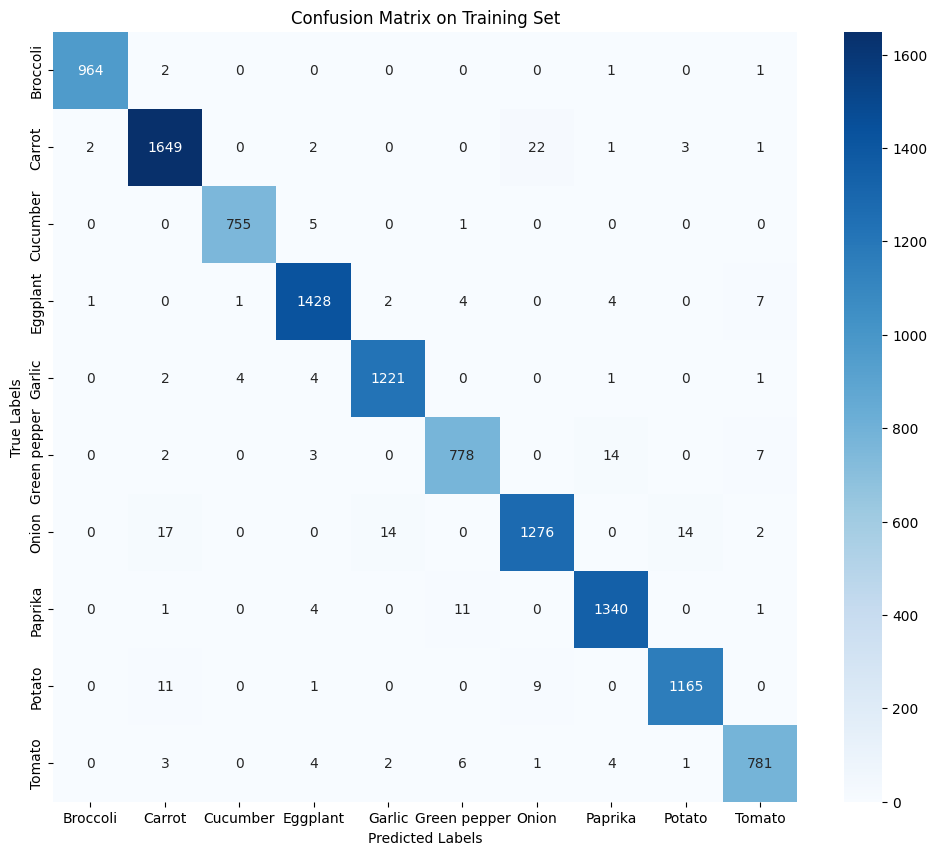

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Function to evaluate the model on the training set and return true/predicted labels
def evaluate_model(model, train_images_path, train_labels_path, label_names, iou_threshold=0.5, conf_threshold=0.5):
    results = model.predict(source=train_images_path, conf=conf_threshold, iou=iou_threshold)
    y_true = []
    y_pred = []

    for result in results:
        # Get the image file name
        image_file = os.path.basename(result.path)

        # Construct the label file path
        label_path = os.path.join(train_labels_path, image_file.replace(".jpg", ".txt"))

        # Read ground truth labels
        true_labels_for_image = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    true_class_id = int(line.strip().split()[0])
                    true_labels_for_image.append(true_class_id)

        # Get predictions for this image
        predicted_labels_for_image = [int(box.cls.cpu().numpy()[0]) for box in result.boxes]

        # Only add to y_true and y_pred if lengths match
        if len(true_labels_for_image) == len(predicted_labels_for_image):
            y_true.extend(true_labels_for_image)
            y_pred.extend(predicted_labels_for_image)
        else:
            print(f"Skipping {image_file} due to mismatch in label counts")

    return y_true, y_pred

# Define paths to training images and labels
train_images_path = "/content/Yasai-Ninshiki-7/train/images"  # Update with actual path
train_labels_path = "/content/Yasai-Ninshiki-7/train/labels"  # Update with actual path

# Assuming your model and label_names are defined
y_true, y_pred = evaluate_model(model, train_images_path, train_labels_path, label_names)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(label_names)))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Training Set')
plt.show()
